In [1]:
import os
import sys
import csv
import pickle
import getpass
import numpy as np
import pandas as pd
from scipy import interpolate

import astropy
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import coordinates
from astropy.nddata import Cutout2D
from astroquery.gaia import Gaia

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import clear_output, display

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
out = 'out\\'
figsave_format = 'pdf'
figsave_dpi = 200

colors = [
    'tab:red',
    'tab:orange',
    'tab:green',
    'tab:blue',
    'tab:purple'
]

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
seaborn_cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)

sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Gaia server query

In [3]:
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour

In [3]:
ra = 132.84223595
dec = 11.80775657
size = 30.0/60.0

l = 0
b = 0
l_size = 30
b_size = 10

gaia_sql = """\
SELECT \
    source_id, ra, dec, l, b, parallax, \
    phot_g_mean_mag, bp_rp, bp_g, radial_velocity \
FROM gaiadr2.gaia_source \
WHERE l BETWEEN {0} - {2} AND {0} + {2} AND \
      b BETWEEN {1} - {3} AND {1} + {3} AND \
      phot_g_mean_mag < 15;""".format(l, b, l_size, b_size)

In [79]:
l = 0
b = 0
l_size = 30
b_size = 12

gaia_sql = """\
SELECT \
    source_id, l, b \
FROM gaiadr2.gaia_source \
WHERE l BETWEEN {0} AND {1} AND \
      b BETWEEN {2} AND {3} AND \
      phot_g_mean_mag < 15;""".format(l-l_size, l+l_size, b-b_size, b+b_size)

In [46]:
rand_min = 0
rand_max = 5e5

gaia_sql = """\
SELECT \
    source_id, ra, dec, l, b, parallax, \
    phot_g_mean_mag, bp_rp, bp_g, radial_velocity \
FROM gaiadr2.gaia_source \
WHERE random_index >= {0} AND random_index <= {1};""".format(rand_min, int(rand_max))

In [76]:
gaia_sql

'SELECT     source_id, l, b FROM gaiadr2.gaia_source WHERE l BETWEEN -60 AND 0 AND       b BETWEEN 0 AND 24 AND       phot_g_mean_mag < 15;'

In [77]:
job = Gaia.launch_job_async(gaia_sql, dump_to_file=False)

INFO: Query finished. [astroquery.utils.tap.core]


In [78]:
r = job.get_results()
r

source_id,l,b
,deg,deg
int64,float64,float64


In [80]:
output = 'random_spot_{0}_{1}_{2}_{3}.csv'.format(l, b, l_size, b_size)
#output = 'random_spot_btw_{0}_{1}.csv'.format(rand_min, rand_max)

In [64]:
r.to_pandas().to_csv(output, index=False, mode='w+')

In [81]:
# Count lines in .csv
with open(output, "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    line_count = 0

    for row_i in csv_reader:
        line_count += 1

    print("Processed {} lines.".format(line_count-1))

Processed 2899256 lines.


In [82]:
with open(output, 'r') as f:
    dr2_data = pd.read_csv(f)

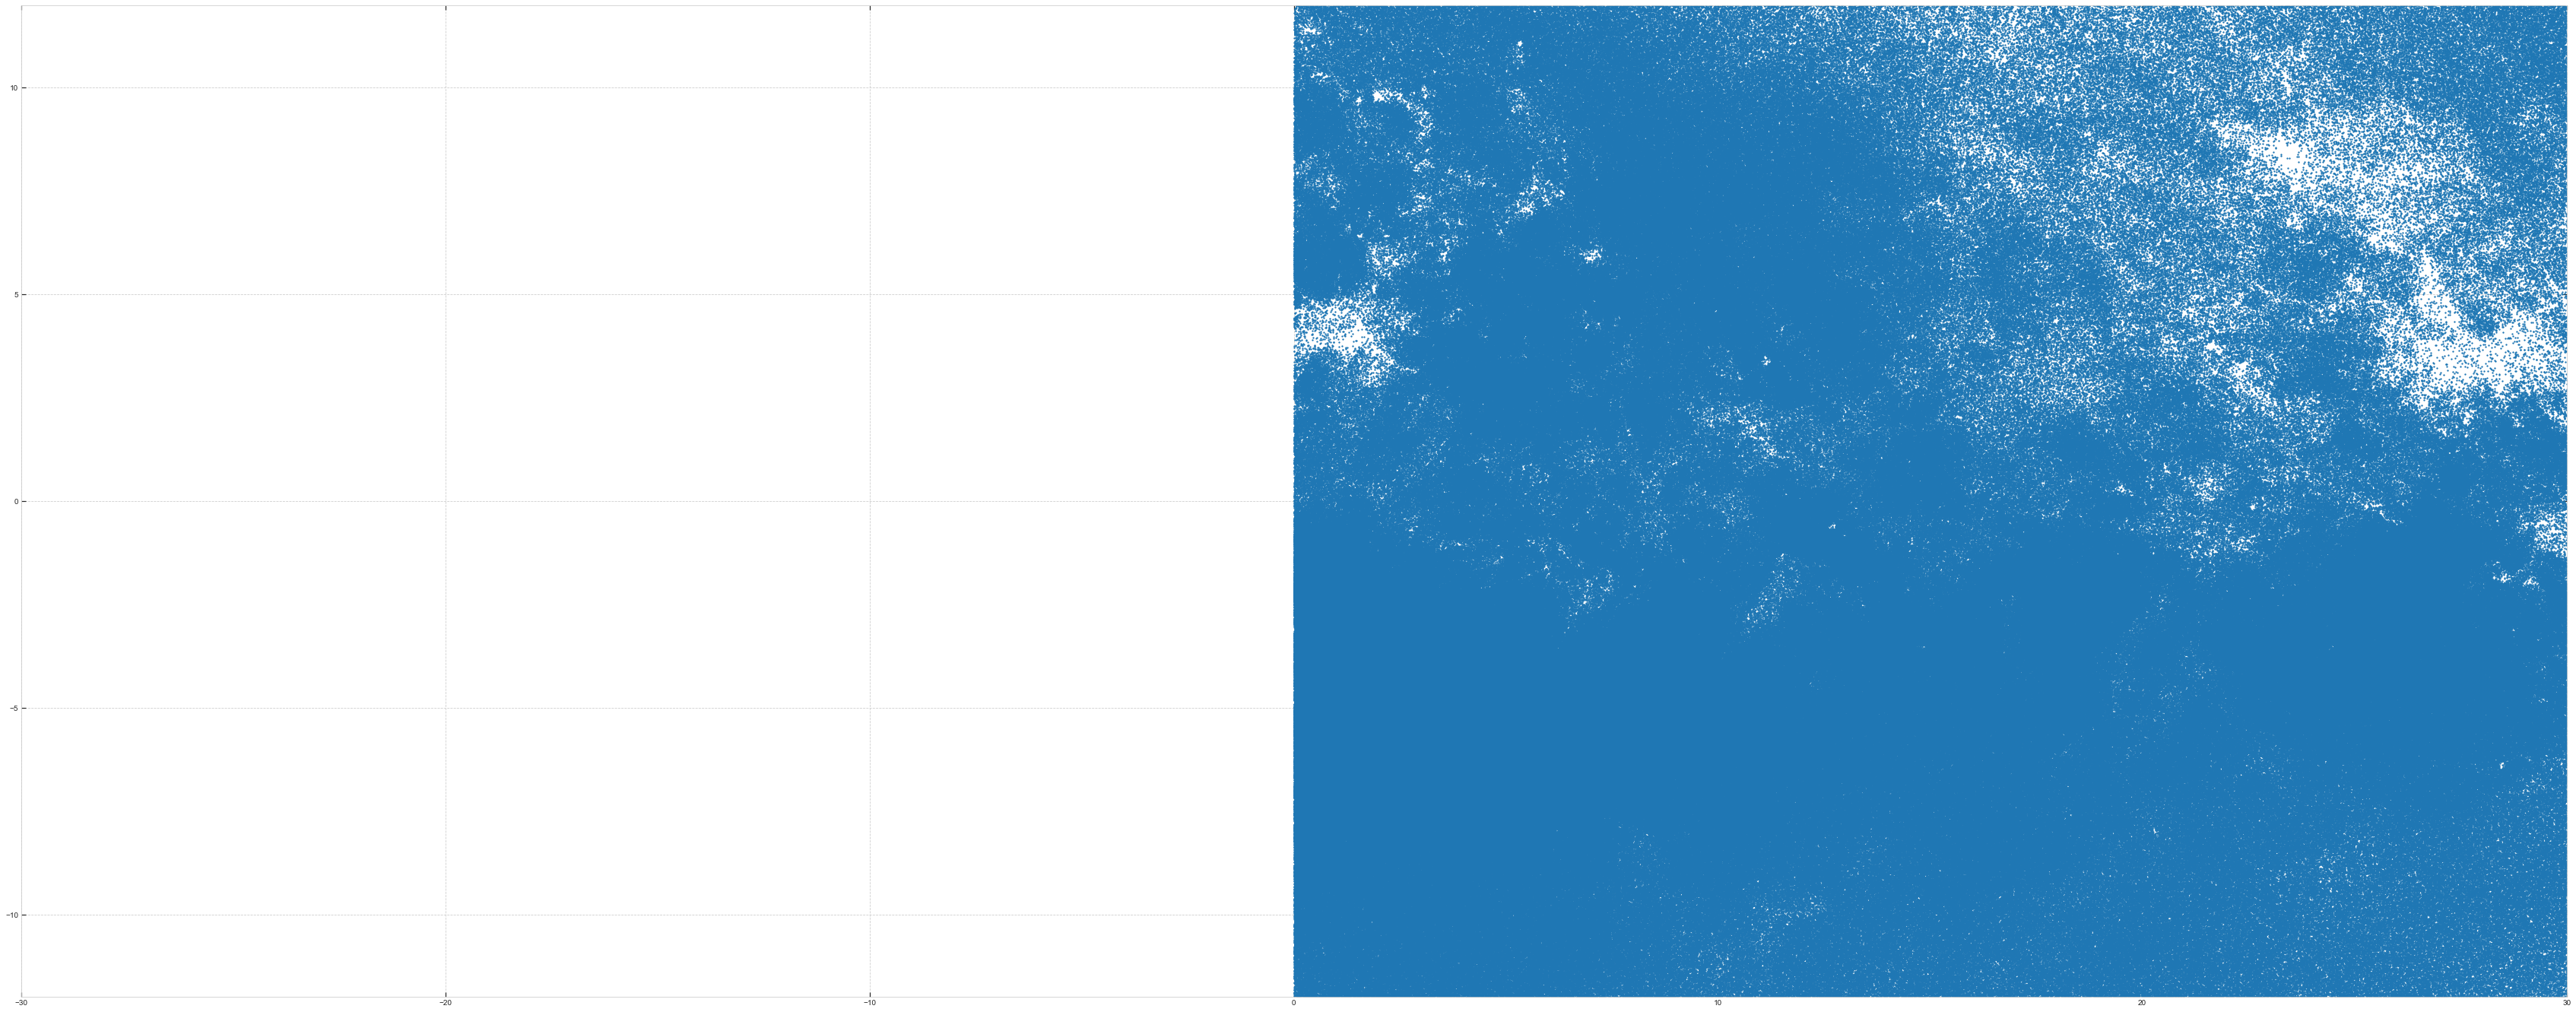

In [83]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2*l_size, nrows*2*b_size))

s_rad = 1.3

axes.set_xlim(l-l_size, l+l_size)
axes.set_ylim(b-b_size, b+b_size)
#axes.set_xlim(np.min(dr2_data.l), np.max(dr2_data.l))
#axes.set_ylim(np.min(dr2_data.b), np.max(dr2_data.b))

axes.scatter(dr2_data.l, dr2_data.b,
             c='tab:blue', s=s_rad**2)

plt.show()

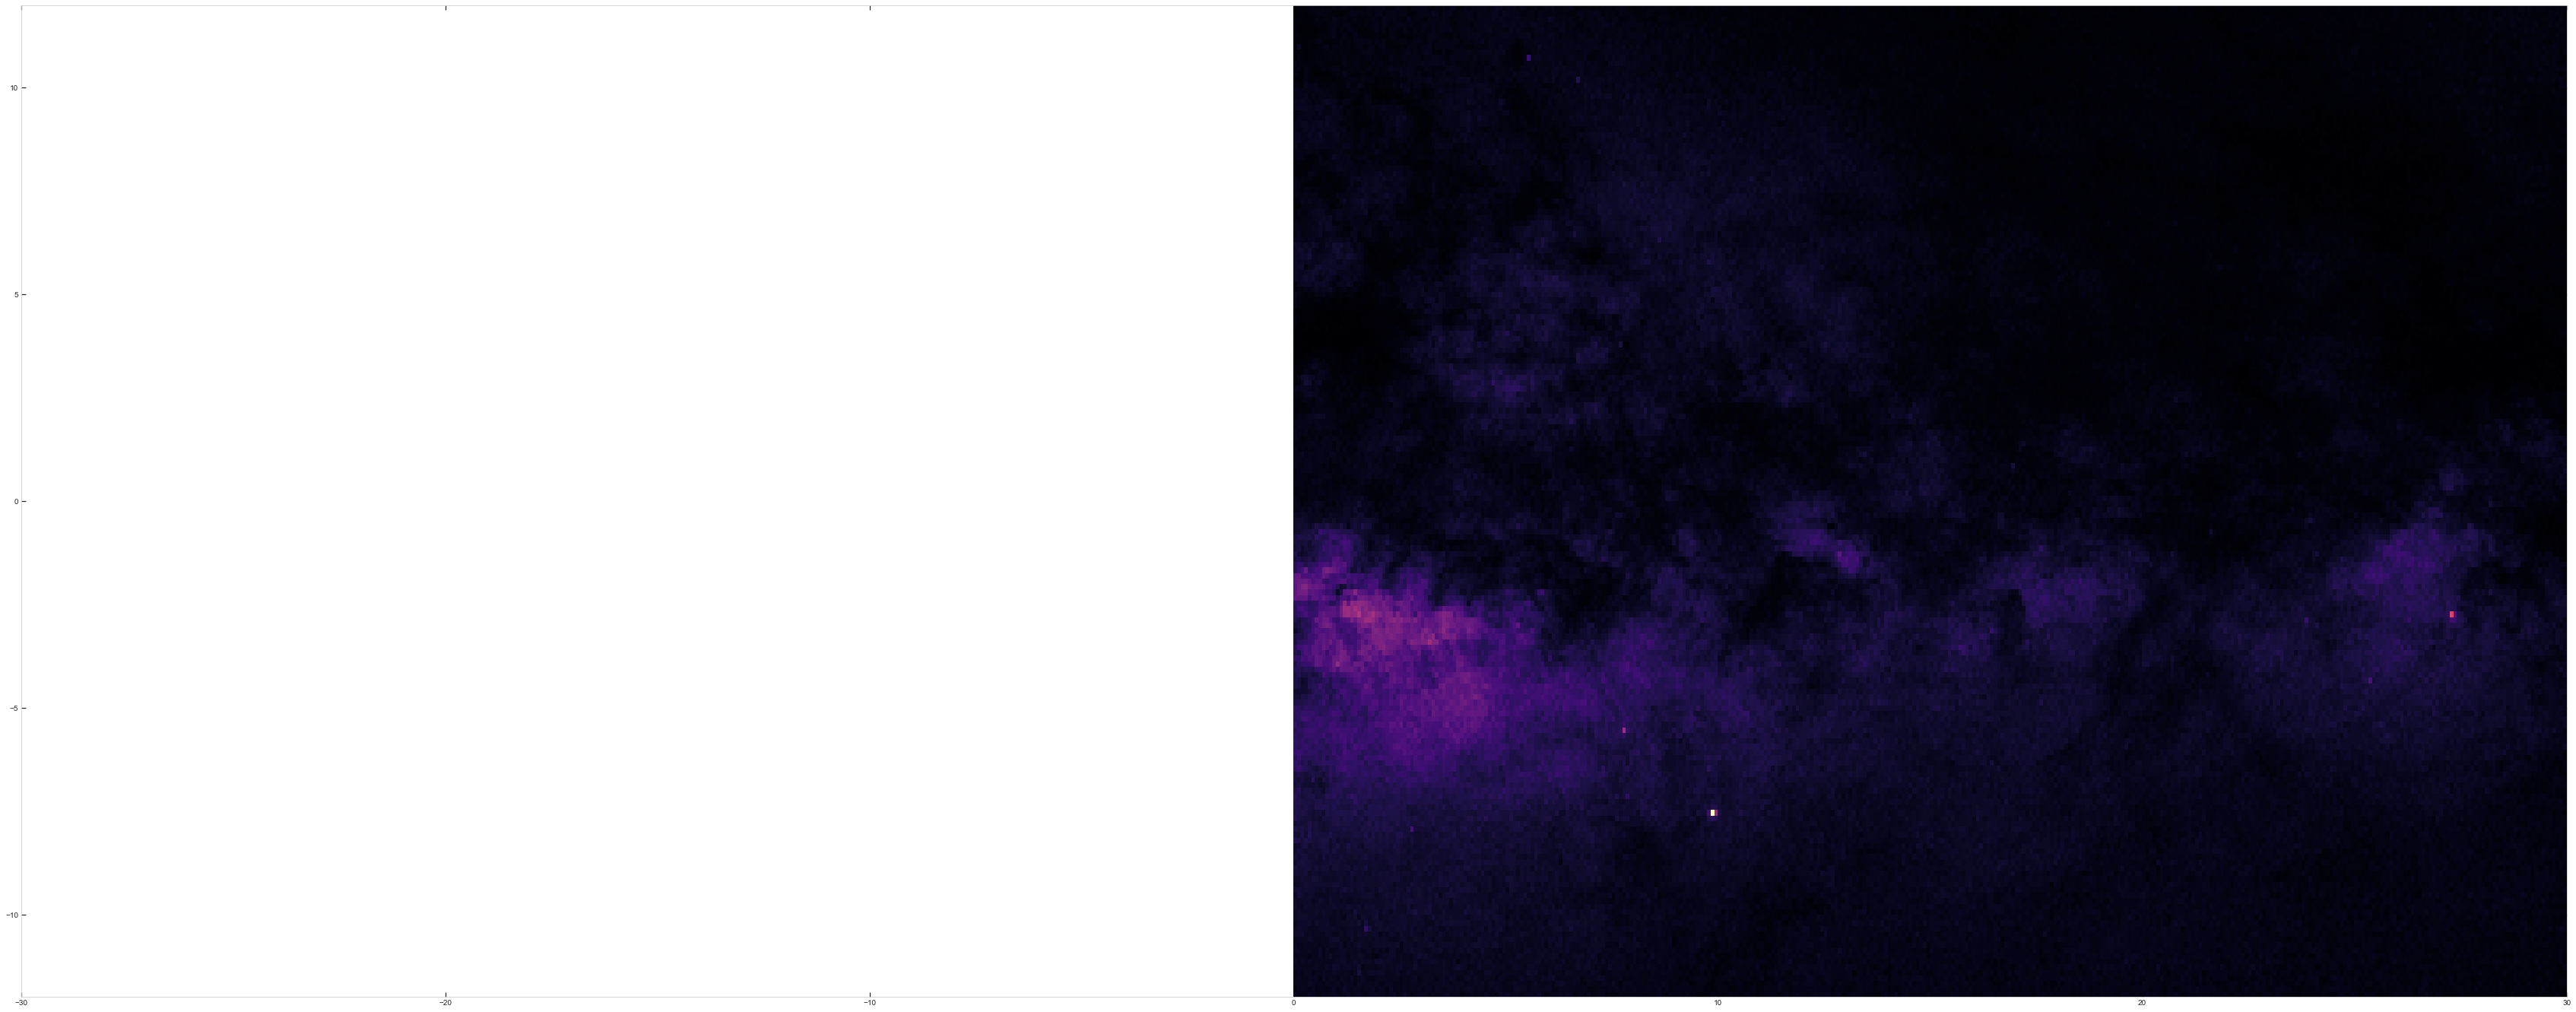

In [84]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2*l_size, nrows*2*b_size))

s_rad = 1.3

dens = axes.hist2d(dr2_data.l, dr2_data.b,
                   bins=(360, 180),
                   range=([[np.nanmin(dr2_data.l),np.nanmax(dr2_data.l)],
                           [np.nanmin(dr2_data.b),np.nanmax(dr2_data.b)]]),
                   cmap=cm.magma, vmin=0, vmax=None)

axes.set_xlim(np.min(dr2_data.l), np.max(dr2_data.l))
axes.set_ylim(np.min(dr2_data.b), np.max(dr2_data.b))

plt.show()

## Add distances and abs magnitude values to data

In [67]:
# Parallax is given is milliarcseconds [mas], which should be converted to arcsec
distance = 1/(dr2_data.parallax.values*0.001)

# M_abs = m_app - 5 * log_10(d_pc) + 5
phot_g_abs_mag = dr2_data.phot_g_mean_mag.values - 5 * np.log10(distance) + 5

<ipython-input-67-1d9d6199a592>:2: RuntimeWarning: invalid value encountered in log10
  phot_g_abs_mag = dr2_data.phot_g_mean_mag.values - 5 * np.log10(distance) + 5


In [99]:
np.count_nonzero(~np.isnan(phot_g_abs_mag))

115842

In [71]:
dr2_data = dr2_data.assign(distance=pd.Series(distance).values)
dr2_data = dr2_data.assign(phot_g_abs_mag=pd.Series(phot_g_abs_mag).values)

In [72]:
def set_colors(arr, cmap, vmin=0, vmax=1):
    
    assert vmin >= 0, "Parameter \'vmin\' should be >=0 !"
    assert vmax <= 1, "Parameter \'vmax\' should be <=1 !"
    
    m = interpolate.interp1d([np.min(arr), np.max(arr)], [vmin, vmax])
    colors = cmap(m(arr))
    
    return colors

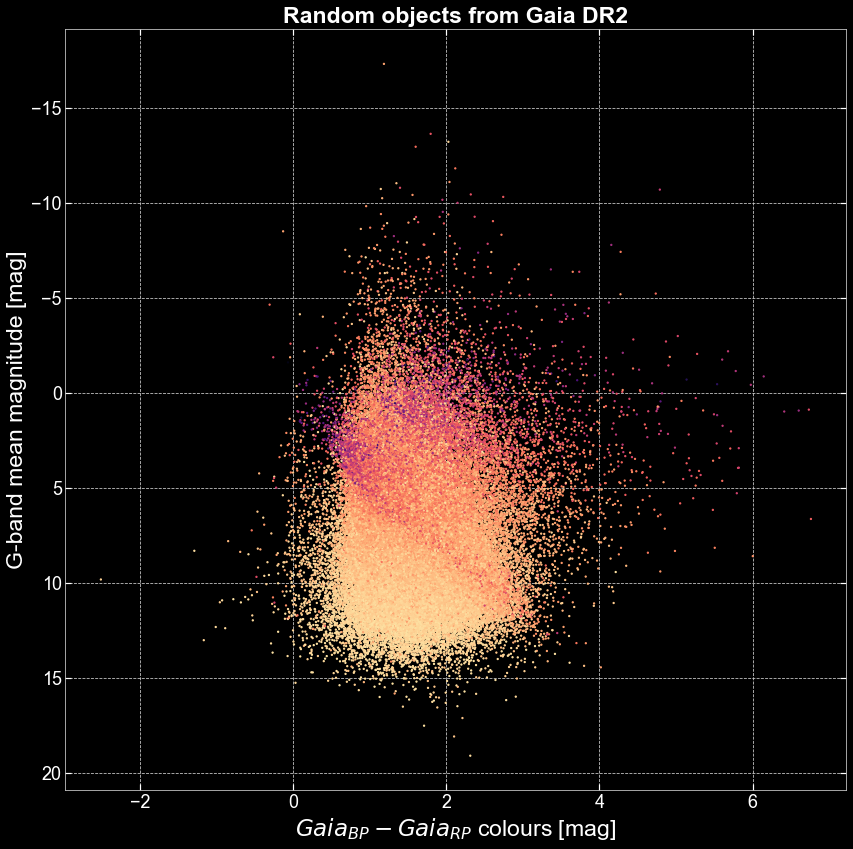

In [74]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14, nrows*14),
                         facecolor='black', subplot_kw=dict(facecolor='black'))

axistitlesize = 23
axisticksize = 18
axislabelsize = 23
s_rad = 1.3

axes.invert_yaxis()

axes.scatter(dr2_data.bp_rp, dr2_data.phot_g_abs_mag,
             color=set_colors(arr=dr2_data.phot_g_mean_mag, cmap=cm.magma, vmin=0, vmax=1),
             s=s_rad**2)

axes.set_title('Random objects from Gaia DR2', fontsize=axistitlesize, fontweight='bold', color='w')
axes.set_xlabel('$Gaia_{BP} - Gaia_{RP}$ colours [mag]', fontsize=axislabelsize, color='w')
axes.set_ylabel('G-band mean magnitude [mag]', fontsize=axislabelsize, color='w')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='w') 

plt.show()

-2.5087624

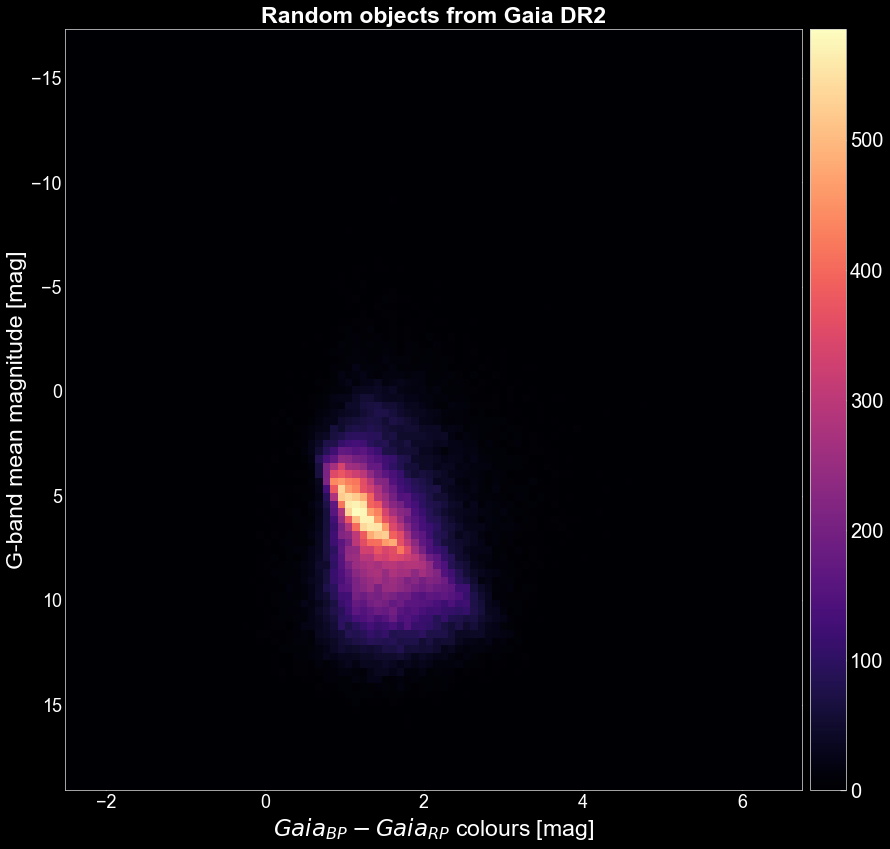

In [89]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14, nrows*14),
                         facecolor='black', subplot_kw=dict(facecolor='black'))

axistitlesize = 23
axisticksize = 18
axislabelsize = 23
axiscbarfontsize = 20
s_rad = 1.3

dens = axes.hist2d(dr2_data.bp_rp, dr2_data.phot_g_abs_mag,
                   bins=(100, 100),
                   range=([[np.nanmin(dr2_data.bp_rp),np.nanmax(dr2_data.bp_rp)],
                           [np.nanmin(dr2_data.phot_g_abs_mag),np.nanmax(dr2_data.phot_g_abs_mag)]]),
                   cmap=cm.magma, vmin=0, vmax=None)
axes.invert_yaxis()

axes.set_title('Random objects from Gaia DR2', fontsize=axistitlesize, fontweight='bold', color='w')
axes.set_xlabel('$Gaia_{BP} - Gaia_{RP}$ colours [mag]', fontsize=axislabelsize, color='w')
axes.set_ylabel('G-band mean magnitude [mag]', fontsize=axislabelsize, color='w')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='w') 

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(mappable=dens[3], cax=cax)
cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='white')

plt.show()